# Cabify Test: The Two Distances Dilemma

---



---
Given the following two methods to calculate distance / time between two points:
- Linear distance: free of charge, using haversine distance
- Road distance: with cost, external API.

The goal is to resolve:
1. Should the company move towards road distance? What's the max price it would 
make sense to pay per query? (make all the assumptions you need, and make them explicit)
2. How would you improve the experimental design? Would you collect any additional data?


## 0. Approach
To extract conclusions we will follow these steps:
1. Libraries and packages: import necessary Python modules
2. Reading data: json file will be read and checked in terms of headers. Column formats and null values will be analyzed.
3. Understanding dataset structure: we will assess how the dataset is configured, what it contains and its internal behaviour, what a row means. Every column will be looked at in a univariate analysis.
4. Understanding the impact of road distance:
* We will define a key variable to assess change between linear-assigned trips and road-assigned trips. There are three options for this purpose:


> A. The key variable is how difficult is to assign one driver to go to pickup point.


> B. The key variable is how much money is made by one trip.


> C. The key variable is how many trips are interrupted before picking up the rider.


- We will make a comparison of the key variable performance between the two samples related to distance type. This analysis has to be statistcally grounded.
5. Maximum cost per API query: we will define a proxy calculation of how much we should be paying for each API call based on number of available drivers, average trip distance and duration, and fixed Cabify fees.
6. Conclusions

## 1. Libraries and packages

In [1]:
!pip install researchpy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import researchpy as rp
import seaborn as sns

from scipy.stats import chi2_contingency, ks_2samp, kstest, anderson, levene

sns.set(color_codes=True)
plt.rc('figure', figsize=(20,10))
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Reading data

In [3]:
#Read received json file
file = '/content/drive/MyDrive/ColabNotebooks/cabify_codetest/intervals_challenge.json'
df_moves = pd.read_json(file, lines=True)
df_moves.head()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type
0,857,5384,2016-10-03 13:00:00.286999941,c00cee6963e0dc66e50e271239426914,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup
2,1249,5847,2016-10-03 13:00:01.670000076,757867f6d7c00ef92a65bfaa3895943f,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup
4,182,743,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup


In [4]:
#Dataset dimensions
num_rows, num_cols = df_moves.shape
print("The dataset has {0} rows and {1} columns".format(num_rows,num_cols))

The dataset has 165170 rows and 7 columns


In [5]:
#Unnecessarily duplicated rows
if df_moves.duplicated().any():
    print("Duplicated full rows")
else: print("Everything is ok")

Everything is ok


In [6]:
#Describe column names and types
df_moves.dtypes

duration              object
distance              object
started_at    datetime64[ns]
trip_id               object
vehicle_id            object
city_id               object
type                  object
dtype: object

It appears that all column names are correctly formatted, so it is not necessary to change any characters (except maybe for column `type`, which is a reserved Python word). However, `duration` and `distance` would need to change from `object` to `numeric` type



### 2.1 Adjusting some variable types

In [7]:
#Changing variable types
df_moves["duration_num"] = pd.to_numeric(df_moves.duration, errors='coerce')
df_moves["distance_num"] = pd.to_numeric(df_moves.distance, errors='coerce')
df_moves.dtypes

duration                object
distance                object
started_at      datetime64[ns]
trip_id                 object
vehicle_id              object
city_id                 object
type                    object
duration_num           float64
distance_num           float64
dtype: object

In [8]:
#Are there any null values?
df_moves.isnull().sum()

duration           0
distance           0
started_at         0
trip_id            0
vehicle_id         0
city_id            0
type               0
duration_num    1157
distance_num    1157
dtype: int64

When transforming the two variables, there were non numeric values that became null values, so let's see if we can just filter them



In [9]:
df_moves[df_moves.duration_num.isnull()]

,duration,distance,started_at,trip_id,vehicle_id,city_id,type,duration_num,distance_num
131832,NA,NA,2016-10-04 16:16:57.677000046,e1a5305515f04de1a32a883e752f5da4,9eceeaf8c8ad105212d6e8eecda02c4a,pentos,driving_to_destination,NaN,NaN
133409,NA,NA,2016-10-04 16:28:50.309999943,13f154ab0c7d17fb2ec203a3a714d6b0,fce3a43cd5f5a43e2d0b929ad604d3b6,pentos,going_to_pickup,NaN,NaN
138211,NA,NA,2016-10-04 17:04:50.207000017,99dc4314729ae959762a9bc2ba681de6,b041d487fdc4afcbdc9d3ce23bfbe59a,pentos,going_to_pickup,NaN,NaN
153973,NA,NA,2016-10-04 19:11:57.548000097,4edd2ed1f5c5401d117b87d70d694f8b,909d1f5607f5796963b0142f8536ccad,pentos,driving_to_destination,NaN,NaN
155979,NA,NA,2016-10-04 19:27:43.782999992,179ec5f2abe307b008d8f5d4b33d29b4,bef0644f66f06d5aa5f547c58845d8b7,pentos,driving_to_destination,NaN,NaN
...,...,...,...,...,...,...,...,...,...
165165,NA,NA,2016-10-04 20:36:10.846999884,d2f81b419daddb90bd701ab9870f47a3,05e4532a59b7bfe65894335d1bc83e4d,volantis,driving_to_destination,NaN,NaN
165166,NA,NA,2016-10-04 20:36:12.719000101,73a07d4504036997306e0e3330529294,bed6dd187f23b3e8d956bb0d1ab0524a,volantis,waiting_for_rider,NaN,NaN
165167,NA,NA,2016-10-04 20:36:14.763000011,d98c047d565bd488b17e08594965c479,31cd2f19d27c0c0c0ca386de72866a81,bravos,driving_to_destination,NaN,NaN
165168,NA,NA,2016-10-04 20:36:15.957999945,ce9a7ae5f76667c9f92b149a1b345a2d,4a555013634506246eed5d801ffbe526,volantis,driving_to_destination,NaN,NaN


They were NA initial values, so we are going to filter those for this analysis. However, this should be confirmed with Data Owner since they may mean something that makes sense to include in our analysis, or substitute with 0-values for example.

In [10]:
df_moves = df_moves[df_moves["duration_num"].notnull()]
df_moves.drop(['duration', 'distance'], axis=1, inplace=True)

In [11]:
df_moves.isnull().sum()

started_at      0
trip_id         0
vehicle_id      0
city_id         0
type            0
duration_num    0
distance_num    0
dtype: int64

In [12]:
num_rows, num_cols = df_moves.shape
print("The dataset has {0} rows and {1} columns".format(num_rows,num_cols))

The dataset has 164013 rows and 7 columns


## 3. Understanding dataset structure

We are going to understand the dataset and restructure it as follows:
- Assuming that each row is a travel interval from the three possible ones, we are interested in rebuilding trips by concatenating the intervals in one row.

### 3.1 Understanding intervals

In [13]:
#We are looking at vehicle intervals, so we expect to find per trip something like: one vehicle going to pickup, one waiting for customer, and one driving to destination.
aux = df_moves.groupby(["trip_id",'type'],as_index=False).vehicle_id.count().sort_values("vehicle_id",ascending=False)
aux

,trip_id,type,vehicle_id
113072,afacd04e18402f482e950ecc17c9f998,going_to_pickup,9
51968,50756ed6622945b0c79147be698c05c3,going_to_pickup,3
118315,b7e65508b9cf020062b8870ae5617cb6,going_to_pickup,3
118718,b88bcaea336bfdafb7140cda332feead,going_to_pickup,2
31736,307bc598c880166cddd630a8d120eba2,going_to_pickup,2
...,...,...,...
54665,54acce63580f54b621bdde7b14b6cdb8,waiting_for_rider,1
54666,54acf7aa8f2207a63a6183365261efcb,driving_to_destination,1
54667,54acf7aa8f2207a63a6183365261efcb,going_to_pickup,1
54668,54acf7aa8f2207a63a6183365261efcb,waiting_for_rider,1


In [14]:
print("There are trips with more than one row per interval type, maximum {0} trips".format(len(aux[aux["vehicle_id"] > 1])))

There are trips with more than one row per interval type, maximum 34 trips


In [15]:
df_moves[df_moves["trip_id"] == "afacd04e18402f482e950ecc17c9f998"]

,started_at,trip_id,vehicle_id,city_id,type,duration_num,distance_num
41788,2016-10-03 19:35:07.676000118,afacd04e18402f482e950ecc17c9f998,9ba0b39afdcc6010ae3a1bb6c50f7e5f,volantis,going_to_pickup,292.0,164.0
42381,2016-10-03 19:40:04.326999903,afacd04e18402f482e950ecc17c9f998,7f301b5d817d377c2d9c5da7cd97f7af,volantis,going_to_pickup,6.0,1.0
42436,2016-10-03 19:40:28.078999996,afacd04e18402f482e950ecc17c9f998,e4fc541b0dc9afa953b939d4298e574f,volantis,going_to_pickup,298.0,898.0
43022,2016-10-03 19:45:32.052999973,afacd04e18402f482e950ecc17c9f998,434c375d4695459846f7ec72889cfd6d,volantis,going_to_pickup,387.0,9.0
43805,2016-10-03 19:52:13.058000088,afacd04e18402f482e950ecc17c9f998,7f708e239bf82367a38fdde52f4e3850,volantis,going_to_pickup,114.0,318.0
44083,2016-10-03 19:54:15.230999947,afacd04e18402f482e950ecc17c9f998,59baf0054cbafa5a2dd697e091986113,volantis,going_to_pickup,45.0,213.0
44204,2016-10-03 19:55:09.642999887,afacd04e18402f482e950ecc17c9f998,bd4452df7540396186496a6ec00f3349,volantis,going_to_pickup,140.0,34.0
44525,2016-10-03 19:57:33.884999990,afacd04e18402f482e950ecc17c9f998,95ba655b5b8af4f5dd7a49667484fda2,volantis,going_to_pickup,149.0,274.0
44818,2016-10-03 20:00:12.289000034,afacd04e18402f482e950ecc17c9f998,802ccd5cd4b8e16877c96f44ecb0094e,volantis,going_to_pickup,1422.0,6156.0
47617,2016-10-03 20:23:54.740000010,afacd04e18402f482e950ecc17c9f998,802ccd5cd4b8e16877c96f44ecb0094e,volantis,waiting_for_rider,839.0,76.0


As we can see, for one trip we can find several vehicles for `going_to_pickup` interval. Do they mean drivers canceling assigned trips until one of them effectively passes to waiting for driver? Do they mean attemps to assign drivers? This could be interesting to explore option A for key variable of measurement.

In any case, there are `going_to_pickup` intervals that did not "succeed" to become a trip.

In [16]:
#Do the other types of inteval have several rows per trip?
aux[aux["vehicle_id"] > 1].type.value_counts()

going_to_pickup      32
waiting_for_rider     2
Name: type, dtype: int64

It really does not feel that those 34 cases hide the clue to the problem so we are filtering them since they seem more like noise or very specific cases. Again, this must be confirmed by the Data Owner because it could mean for example the attempts of assign available drivers, which would be precisely very relevant for the present analysis, but in that case we would need more cases like those.

After getting rid of them, we can no longer explore option A for the key variable to measure changes between linear and road distance.


In [17]:
#Let's filter those trips with multiple pickups and waits for rider
weird_trips = aux[(aux["vehicle_id"] > 1)].trip_id.unique()

In [18]:
df_moves = df_moves[~df_moves["trip_id"].isin(weird_trips)]
num_rows, num_cols = df_moves.shape
print("The dataset has {0} rows and {1} columns".format(num_rows,num_cols))

The dataset has 163884 rows and 7 columns


#### 3.1.1 Rebulding trips

In [19]:
#We attempt to rebuild trips "horizontally"
df_moves_going2pickup = df_moves[df_moves["type"] == "going_to_pickup"].rename({'vehicle_id': 'vehicle_id_pickup'}, axis='columns')
df_moves_waiting = df_moves[df_moves["type"] == "waiting_for_rider"].rename({'vehicle_id': 'vehicle_id_waiting'}, axis='columns')
df_moves_destination = df_moves[df_moves["type"] == "driving_to_destination"].rename({'vehicle_id': 'vehicle_id_destination'}, axis='columns')

df_moves.type.value_counts()

going_to_pickup           58138
waiting_for_rider         53672
driving_to_destination    52074
Name: type, dtype: int64

In [20]:
#Just a silly check
print("The dataset with pickups has {0} rows".format(len(df_moves_going2pickup)))
print("The dataset with waits has {0} rows".format(len(df_moves_waiting)))
print("The dataset with drives has {0} rows".format(len(df_moves_destination)))

The dataset with pickups has 58138 rows
The dataset with waits has 53672 rows
The dataset with drives has 52074 rows


In [21]:
#Let's find the driver waiting for the rider, for each pickup interval
df_moves_going2pickup = df_moves_going2pickup.merge(df_moves_waiting[["trip_id","vehicle_id_waiting","started_at","distance_num","duration_num"]], how="left",left_on=["trip_id"],right_on=["trip_id"],suffixes=[None,"_waiting"])

In [22]:
#Let's find the final assigned driver for each pickup interval
df_trips = df_moves_going2pickup.merge(df_moves_destination[["trip_id","started_at","vehicle_id_destination","distance_num","duration_num"]], how="left",left_on=["trip_id"],right_on=["trip_id"],suffixes=[None,"_destination"])

In [23]:
num_rows_trips, num_cols_trips = df_trips.shape
print("The final dataset with transposed trips has {0} rows".format(num_rows_trips))

The final dataset with transposed trips has 58138 rows


We did not generate duplicates through the left join, so everything seems to be in order.
Let's look at unfinished trips:

In [24]:
df_trips[(df_trips["vehicle_id_pickup"] != df_trips["vehicle_id_waiting"])]

,started_at,trip_id,vehicle_id_pickup,city_id,type,duration_num,distance_num,vehicle_id_waiting,started_at_waiting,distance_num_waiting,duration_num_waiting,started_at_destination,vehicle_id_destination,distance_num_destination,duration_num_destination
57,2016-10-03 13:01:21.957999945,0c59601f6a0c44e2abe3c330dc27a944,6b5981caa707d628799fa82755fcd256,volantis,going_to_pickup,40.0,4.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN
65,2016-10-03 13:01:36.394999981,a9255b8eaa38d5cd89e9427b59f162a2,41d8d46d1b755345b2bd065e4e0947ec,volantis,going_to_pickup,21.0,94.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN
74,2016-10-03 13:01:48.257999896,3f10db13b3e2a750306d07bd0b534110,071c3a78df37df435f93046e5cb078fb,pentos,going_to_pickup,279.0,0.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN
79,2016-10-03 13:01:56.846999884,8ca0cf47e5d337fd9322559d73f81872,11c41964f1944b0f533a2f72c09eb181,pentos,going_to_pickup,74.0,2640.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN
80,2016-10-03 13:01:57.448999882,50b11535fd0ce22beab5de8306e5356e,53c625ef89e2b84ff2baba63e06207f2,pentos,going_to_pickup,37.0,0.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58133,2016-10-04 20:33:03.806999922,139be1f79b3918d6e2d975fe18da17df,7a7b7c6ae0671ea05ac039fe4d36874a,volantis,going_to_pickup,182.0,222.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN
58134,2016-10-04 20:33:14.130000114,380edce2f69a2d515eb19e54648f515d,7d4c53b2a53cf9ffdee4d9f9f027be3a,volantis,going_to_pickup,22.0,0.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN
58135,2016-10-04 20:33:28.573999882,083e32f16268d2c9cd9911dbd2e6f73a,57aa029c4c246d713ed03a75cc72700a,volantis,going_to_pickup,77.0,285.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN
58136,2016-10-04 20:33:49.171999931,0b8452ca0e6924807ef46a39dcf93d65,05f5cb64e8bfc417e56437e6324d367a,bravos,going_to_pickup,17.0,88.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN


In [25]:
df_trips[(df_trips["vehicle_id_waiting"] != df_trips["vehicle_id_destination"]) & (~df_trips["vehicle_id_waiting"].isnull())]

,started_at,trip_id,vehicle_id_pickup,city_id,type,duration_num,distance_num,vehicle_id_waiting,started_at_waiting,distance_num_waiting,duration_num_waiting,started_at_destination,vehicle_id_destination,distance_num_destination,duration_num_destination
31,2016-10-03 13:00:44.881999969,273b84878d3a89885c8688691ca83b98,6b8ee6a3b143943440cbdd4981b35558,volantis,going_to_pickup,670.0,5307.0,6b8ee6a3b143943440cbdd4981b35558,2016-10-03 13:11:54.878999949,19.0,455.0,NaT,NaN,NaN,NaN
40,2016-10-03 13:00:54.089999914,e4df5ad7dbe8035009321f74e14774e6,8cbf4c3c3743ffb2d2b24b8d1c7a5847,pentos,going_to_pickup,334.0,848.0,8cbf4c3c3743ffb2d2b24b8d1c7a5847,2016-10-03 13:06:28.338999987,139.0,607.0,NaT,NaN,NaN,NaN
62,2016-10-03 13:01:31.061000109,44a17d86107a98b8fa5da7dfffe8739d,d691be7f14c78d09d5c0c487c5846bfe,pentos,going_to_pickup,14.0,0.0,d691be7f14c78d09d5c0c487c5846bfe,2016-10-03 13:01:45.246000051,38.0,605.0,NaT,NaN,NaN,NaN
263,2016-10-03 13:06:40.013999939,ba324c527058e1eedb1d772e23e7910b,ddef208840781f8b4211a294f5a86d83,pentos,going_to_pickup,127.0,340.0,ddef208840781f8b4211a294f5a86d83,2016-10-03 13:08:47.418999910,51.0,34.0,NaT,NaN,NaN,NaN
363,2016-10-03 13:09:28.180000067,1d31387af4a004cf8773af10c43926e4,60675c7e4ba95cf4e767ad67fa9c8112,bravos,going_to_pickup,152.0,142.0,60675c7e4ba95cf4e767ad67fa9c8112,2016-10-03 13:11:59.760999918,648.0,161.0,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58118,2016-10-04 20:31:54.400000095,6b07ecf150d93ef695d65d631127d217,63ae0d64e03aee9444ae9e79b53feb5e,bravos,going_to_pickup,194.0,722.0,63ae0d64e03aee9444ae9e79b53feb5e,2016-10-04 20:35:08.357000113,0.0,41.0,NaT,NaN,NaN,NaN
58121,2016-10-04 20:32:11.400000095,97979191d59fd1befa1156902352642c,a3e0ec5c6ea97b306dbe4fcabd47f2b5,bravos,going_to_pickup,122.0,495.0,a3e0ec5c6ea97b306dbe4fcabd47f2b5,2016-10-04 20:34:12.934000015,0.0,13.0,NaT,NaN,NaN,NaN
58125,2016-10-04 20:32:17.328000069,61ceb069dbc9179c7f5c26550a1696f0,46bec27740054d4ed5fd9fcc21152d24,volantis,going_to_pickup,73.0,381.0,46bec27740054d4ed5fd9fcc21152d24,2016-10-04 20:33:30.089999914,0.0,49.0,NaT,NaN,NaN,NaN
58127,2016-10-04 20:32:31.914999962,3036676099319d2d5a75f82bbb1778bf,2b40f41fc8f8a815bce1b3bdbd6a4c55,volantis,going_to_pickup,105.0,163.0,2b40f41fc8f8a815bce1b3bdbd6a4c55,2016-10-04 20:34:17.086999893,0.0,2.0,NaT,NaN,NaN,NaN


So we are observing that:
- a complete simple trip is one that has one driver going to pickup, the same driver is waiting for rider, and then the same driver is driving to destination. There are not complete trips with different drivers per interval.
- There are 4645 trips interrupted during pickup and before waiting for rider.
- There are 1634 trips interrupted during waiting for rider and before starting going to destination. 

In [26]:
df_trips.drop(columns=['type'],inplace=True)

### 3.2 Building distance type

In [27]:
#First let's build the type of distance applied from the trip_id
values_first_digit = df_trips["trip_id"].apply(lambda x: x[0])
values_first_digit.unique()

array(['4', 'd', '0', '1', 'a', '2', '3', 'b', '9', 'e', '6', 'c', 'f',
       '7', '8', '5'], dtype=object)

In [28]:
#All characters appear to be lower case
##These two lists are hardcoded as stated in the problem description
digits_road = ['0','1','2','3','4','5','6','7','8']
digits_linear = ['9','a','b','c','d','e','f','g','h']

df_trips["dist_type"] = df_trips["trip_id"].apply(lambda x: 'road' if x[0] in digits_road else 'linear')
df_trips.head()

,started_at,trip_id,vehicle_id_pickup,city_id,duration_num,distance_num,vehicle_id_waiting,started_at_waiting,distance_num_waiting,duration_num_waiting,started_at_destination,vehicle_id_destination,distance_num_destination,duration_num_destination,dist_type
0,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,245.0,1248.0,8336b28f24c3e7a1e3d582073b164895,2016-10-03 13:04:06.068000078,12.0,226.0,2016-10-03 13:07:52.525000095,8336b28f24c3e7a1e3d582073b164895,7309.0,1700.0,road
1,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,471.0,2585.0,81b63920454f70b6755a494e3b28b3a7,2016-10-03 13:07:52.410000086,2.0,18.0,2016-10-03 13:08:10.694999933,81b63920454f70b6755a494e3b28b3a7,2813.0,403.0,linear
2,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,182.0,743.0,b73030977cbad61c9db55418909864fa,2016-10-03 13:03:03.664999962,32.0,16.0,2016-10-03 13:03:19.204999924,b73030977cbad61c9db55418909864fa,2749.0,776.0,road
3,2016-10-03 13:00:02.154000044,158e7bc8d42e1d8c94767b00c8f89568,126e868fb282852c2fa95d88878686bf,volantis,599.0,1351.0,126e868fb282852c2fa95d88878686bf,2016-10-03 13:10:01.007999897,18.0,9.0,2016-10-03 13:10:10.292999983,126e868fb282852c2fa95d88878686bf,4088.0,1546.0,road
4,2016-10-03 13:00:05.637000084,d3e6e8fb50c02d66feca2c60830c4fcc,b0906e917dc5cc0bcba190fd80079a74,bravos,1525.0,2674.0,b0906e917dc5cc0bcba190fd80079a74,2016-10-03 13:25:30.480999947,0.0,5.0,2016-10-03 13:25:36.022000074,b0906e917dc5cc0bcba190fd80079a74,6499.0,1987.0,linear


### 3.3 Looking at each variable

In [29]:
names_vars_id = ["trip_id", "vehicle_id_pickup", "vehicle_id_waiting", "vehicle_id_destination"]
names_vars_object = [name for name, kind in df_trips.dtypes.iteritems() if 'object' in str(kind) and name not in names_vars_id]
names_vars_float = [name for name, kind in df_trips.dtypes.iteritems() if 'float' in str(kind)]

In [30]:
df_trips.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning an

,started_at,trip_id,vehicle_id_pickup,city_id,duration_num,distance_num,vehicle_id_waiting,started_at_waiting,distance_num_waiting,duration_num_waiting,started_at_destination,vehicle_id_destination,distance_num_destination,duration_num_destination,dist_type
count,58138,58138,58138,58138,58138.000000,5.813800e+04,53493,53493,53493.000000,53493.000000,51859,51859,51859.000000,51859.000000,58138
unique,58117,58138,4739,3,NaN,NaN,4704,53472,NaN,NaN,51843,4681,NaN,NaN,2
top,2016-10-04 18:41:09.742000103,caa9527e710bb38361dae919514d0fdb,a3e0ec5c6ea97b306dbe4fcabd47f2b5,pentos,NaN,NaN,6661ee4bee90709e97c50a6bcb5ac682,2016-10-04 19:19:11.882999897,NaN,NaN,2016-10-04 16:20:34.881999969,6661ee4bee90709e97c50a6bcb5ac682,NaN,NaN,road
freq,2,1,57,39834,NaN,NaN,49,2,NaN,NaN,2,48,NaN,NaN,32944
first,2016-10-03 13:00:00.852999926,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-03 13:00:16.836999893,NaN,NaN,2016-10-03 13:01:01.734999895,NaN,NaN,NaN,NaN
last,2016-10-04 20:34:39.753000021,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-04 20:36:06.243000031,NaN,NaN,2016-10-04 20:32:19.714999914,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,299.777013,9.833881e+02,NaN,NaN,38.478549,75.002673,NaN,NaN,4975.946046,949.307102,NaN
std,NaN,NaN,NaN,NaN,289.965887,1.046696e+04,NaN,NaN,222.637736,198.229722,NaN,NaN,5312.141254,653.970330,NaN
min,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,3.000000,NaN
25%,NaN,NaN,NaN,NaN,141.000000,3.100000e+02,NaN,NaN,0.000000,9.000000,NaN,NaN,2263.000000,552.500000,NaN


#### 3.3.1 Categorical variables

In [31]:
#Let's look at the three cities, since there is obviously granularity at this level
df_trips.city_id.value_counts() / num_rows_trips * 100

pentos      68.516289
volantis    21.337163
bravos      10.146548
Name: city_id, dtype: float64

In [32]:
#Let's look at distance type
df_trips[["city_id","dist_type"]].value_counts()

city_id   dist_type
pentos    road         22472
          linear       17362
volantis  road          7127
          linear        5278
bravos    road          3345
          linear        2554
dtype: int64

In [33]:
#Let's look at demand's hour
df_trips["started_at_hour"] = df_trips["started_at"].dt.hour
aux = df_trips.groupby(["city_id","started_at_hour"],as_index=False).vehicle_id_pickup.count()

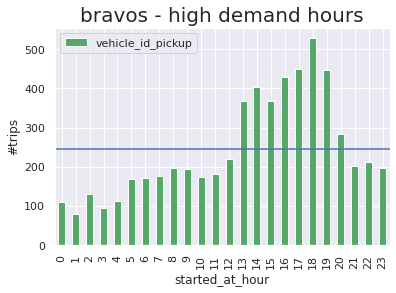

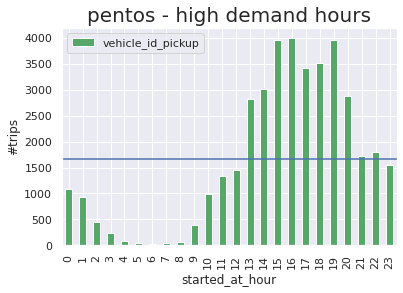

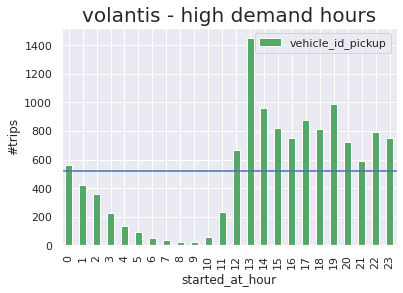

In [34]:
for city in aux.city_id.unique():
  fig,ax= plt.subplots()

  aux[aux["city_id"] == city].plot(x="started_at_hour", y= "vehicle_id_pickup",kind="bar", ax=ax, color='g',figsize=(6,4))

  ax.set_xlabel("started_at_hour")
  ax.set_ylabel("#trips")
  ax.set_title((city + " - high demand hours"), fontsize=20)

  # use axhline
  mean = aux[aux["city_id"] == city]["vehicle_id_pickup"].mean()
  ax.axhline(mean)

General conclusions:
- It appears that we only have data for two days and not five, specifically

Monday 3th October, 2016

Tuesday 4th October, 2016

That might not be significant enough. Trips do not behave the same during the whole week.
- In Bravos and Pentos, high demand runs from 13pm to 20pm
- In Volantis is not that clear, but for the sake of simplicity let's say it's the same. 
- Maybe due to city size (or market share), the proportion of trips by city is not homogeneouly distributed, being Pentos the city with a 69% of trips. We should include the city in the "groupby" clause from now on.
- We have a fairly proportioned distribution of road distance and linear distance intervals in each city.

#### 3.3.1 Numerical variables

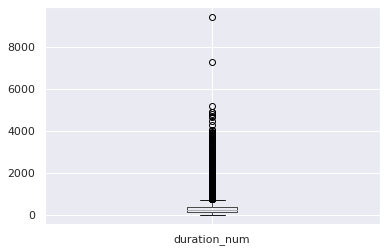

In [35]:
#Distribution of pickup interval duration
df_trips.boxplot(column="duration_num")

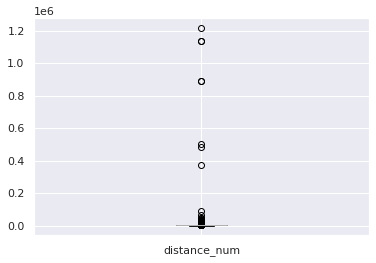

In [36]:
#Distribution of pickup interval distance
df_trips.boxplot(column="distance_num")

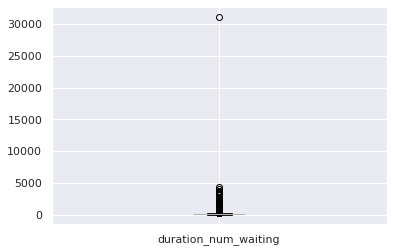

In [37]:
#Distribution of waiting interval duration
df_trips.boxplot(column="duration_num_waiting")

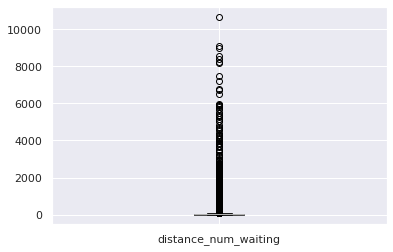

In [38]:
#Distribution of waiting interval distance
df_trips.boxplot(column="distance_num_waiting")

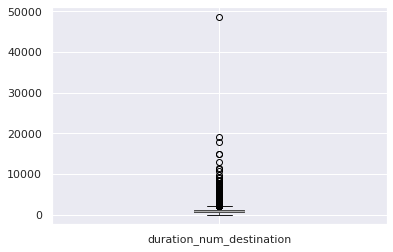

In [39]:
#Distribution of going to destination interval duration
df_trips.boxplot(column="duration_num_destination")

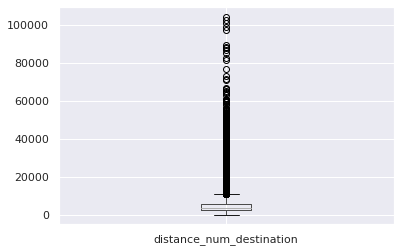

In [40]:
#Distribution of going to destination interval distance
df_trips.boxplot(column="distance_num_destination")

It seems that these variables are very dense at the center, but with lots of outliers so let's study them.
For instance:
* a wait that takes 30000 sec long means a 8h long wait.
* a pickup that is more than 100km really is going from one city to another, which mighty be reasonable for a trip but not really for a pickup.
* pickups should be, in theory, a lot shorter than what we are finding in the dataset

Let's look at the IQR:


In [41]:
#Obtain Q1 and Q3
col_iqr_values = []

for col in names_vars_float:
    q1, q3 = df_trips[col].quantile([0.25,0.75])
    col_iqr_values.append((col,q1,q3))

In [42]:
n = 4 #we are trying [1.5:0.5:4]
col_limits_values = {}
for name, q1, q3 in col_iqr_values:
    iqr = q3-q1
    lower_lim = q1 - iqr*n
    upper_lim = q3 + iqr*n

    outliers_low = len(df_trips[df_trips[name] < lower_lim])
    outliers_up = len(df_trips[df_trips[name] > upper_lim])
    
    col_limits_values[name] = (lower_lim,upper_lim)

    print("In column {0} there are {1} low-outliers and {2} up-outliers".format(name,outliers_low,outliers_up))

col_limits_values

In column duration_num there are 0 low-outliers and 879 up-outliers
In column distance_num there are 0 low-outliers and 846 up-outliers
In column distance_num_waiting there are 0 low-outliers and 2328 up-outliers
In column duration_num_waiting there are 0 low-outliers and 1857 up-outliers
In column distance_num_destination there are 0 low-outliers and 991 up-outliers
In column duration_num_destination there are 0 low-outliers and 196 up-outliers


{'distance_num': (-2730.0, 4110.0),
 'distance_num_destination': (-11815.0, 19860.5),
 'distance_num_waiting': (-92.0, 115.0),
 'duration_num': (-779.0, 1291.0),
 'duration_num_destination': (-2005.5, 3750.0),
 'duration_num_waiting': (-283.0, 374.0)}

Even with an expanding factor of 4, there are several outliers related to this specific sample. We should not *break* the unit of trips by filtering so many rows, specially without having an expert stakeholder to discuss this issue with and specially for this experiment that tries to assess distance calculation methods, but certain values seem really weird (for waits above all).

We definitely would need the opinion of the Data Owner to tell if these are errors or normal values that we can accept.

In [43]:
#We do not need to limit the lower bound since it's naturally 0 (see describe cell)
df_trips = df_trips[df_trips["duration_num"] <= col_limits_values["duration_num"][1]]
df_trips = df_trips[df_trips["distance_num"] <= col_limits_values["distance_num"][1]]

In [44]:
df_trips[["city_id","dist_type"]].value_counts()

city_id   dist_type
pentos    road         22310
          linear       17252
volantis  road          6913
          linear        5125
bravos    road          2893
          linear        2244
dtype: int64

In [45]:
num_rows_trips, num_cols_trips = df_trips.shape
print("The trips dataset has {0} rows and {1} columns".format(num_rows_trips,num_cols_trips))

The trips dataset has 56737 rows and 16 columns


## 4. Understanding the impact of road distance

- The dataset, being limited to provided columns, does not seem enough to compare the actual performance of both distances (the estimated distance, road or linear, is missing).
- We need to define how to measure impact according to bussiness terms. We can use this two options:

> B. The key variable is how much money is made by one trip.

> C. The key variable is how many trips are interrupted before picking up the rider.


In [46]:
#Let's also build dummies for distance type
df_trips["dist_type_aux"] = df_trips["dist_type"]
df_trips = pd.get_dummies(df_trips,prefix="dist_type",columns=["dist_type_aux"])

### 4.1 Measure of successful trip option C
For each trip row, we mark if it is an unfinished trip before waiting for rider, or an unfinished trip before going to destination.

In [47]:
df_trips["unfinished_before_waiting"] = df_trips["vehicle_id_waiting"].isnull().astype(int)
df_trips["unfinished_before_going2dest"] = (~df_trips["vehicle_id_waiting"].isnull() & df_trips["vehicle_id_destination"].isnull()).astype(int)
df_trips["completed"] = (~df_trips["vehicle_id_pickup"].isnull() & ~df_trips["vehicle_id_waiting"].isnull() & ~df_trips["vehicle_id_destination"].isnull()).astype(int)

In [48]:
#Let's see the frequencies by city
df_trips.groupby(["city_id","dist_type",'unfinished_before_waiting','unfinished_before_going2dest']).trip_id.count()

city_id   dist_type  unfinished_before_waiting  unfinished_before_going2dest
bravos    linear     0                          0                                1795
                                                1                                  60
                     1                          0                                 389
          road       0                          0                                2334
                                                1                                  74
                     1                          0                                 485
pentos    linear     0                          0                               15501
                                                1                                 533
                     1                          0                                1218
          road       0                          0                               20114
                                                1              

It seems that both types of distance are very similar in terms of completed trips, road distance being slightly higher (less that 1point%) in Bravos and Pentos.

In [49]:
df_trips.groupby(["dist_type",'unfinished_before_waiting','unfinished_before_going2dest']).trip_id.count()

dist_type  unfinished_before_waiting  unfinished_before_going2dest
linear     0                          0                               21948
                                      1                                 699
           1                          0                                1974
road       0                          0                               28715
                                      1                                 880
           1                          0                                2521
Name: trip_id, dtype: int64

If we skip the city in the analysis, we can see that road distance is slightly better: more completed trips, and less unfinished trips during pickups.
Interruptions during pickups seem the most related to bad distance estimations, since it is the time when the rider discovers the assigned driver and when he/she might think "this driver is too far".

#### 4.1.1 Correlationships
Let's look at the correlations between the distance types and the type of trip in terms of interruptions

In [50]:
df_trips[["city_id","completed", "unfinished_before_waiting","unfinished_before_going2dest","dist_type_road","dist_type_linear"]].groupby(["city_id"]).corr()

completed  ...  dist_type_linear
city_id                                           ...                  
bravos   completed                      1.000000  ...         -0.008573
         unfinished_before_waiting     -0.916411  ...          0.007531
         unfinished_before_going2dest  -0.331230  ...          0.003607
         dist_type_road                 0.008573  ...         -1.000000
         dist_type_linear              -0.008573  ...          1.000000
pentos   completed                      1.000000  ...         -0.005070
         unfinished_before_waiting     -0.823265  ...          0.002537
         unfinished_before_going2dest  -0.527386  ...          0.005125
         dist_type_road                 0.005070  ...         -1.000000
         dist_type_linear              -0.005070  ...          1.000000
volantis completed                      1.000000  ...          0.001966
         unfinished_before_waiting     -0.864821  ...          0.001401
         unfinished_before_going2dest  -0.465938  ...         -0.006382
         dist_type_road                -0.001966  ...         -1.000000
         dist_type_linear               0.001966  ...          1.000000

[15 rows x 5 columns]

As we can see, in none of the cities, linear or road distance are strongly correlated with unfinished trips. What we do observe is that linear distance is negatively correlated (poorly) with completed trips, and road distance is negatively correlated (poorluy) with unfinished trips.

In [51]:
df_trips[["completed", "unfinished_before_waiting","unfinished_before_going2dest","dist_type_road","dist_type_linear"]].corr()

,completed,unfinished_before_waiting,unfinished_before_going2dest,dist_type_road,dist_type_linear
completed,1.000000,-0.847155,-0.488647,0.004278,-0.004278
unfinished_before_waiting,-0.847155,1.000000,-0.049630,-0.003081,0.003081
unfinished_before_going2dest,-0.488647,-0.049630,1.000000,-0.002982,0.002982
dist_type_road,0.004278,-0.003081,-0.002982,1.000000,-1.000000
dist_type_linear,-0.004278,0.003081,0.002982,-1.000000,1.000000


Same conclusions if we skip the city

#### 4.1.2 Chi-square test
Let's see if road distance variable is associated somehow with completed trips

H0 = the variables are not associated

HA = the variables are associated

In [52]:
#Road distance vs completed trips
for city in df_trips.city_id.unique():
  print("---------------{0}---------------".format(city))
  chisqtest = pd.crosstab(df_trips[df_trips["city_id"] == city].completed, df_trips[df_trips["city_id"] == city].dist_type_road, margins=True)
  chisqtest_matrix = np.array([chisqtest.iloc[0][0:5].values, chisqtest.iloc[1][0:5].values])
  stat, p, dof, aux = chi2_contingency(chisqtest_matrix)

  alpha = 0.05
  print("Chi2: {0}".format(str(stat)))
  print("p-value: {0}".format(str(p)))
  if p <= alpha: 
    print('Reject H0') 
  else: 
    print('Not Reject H0') 

---------------volantis---------------
Chi2: 0.04652097545931239
p-value: 0.9770079520402367
Not Reject H0
---------------bravos---------------
Chi2: 0.3775223964657808
p-value: 0.827984207179995
Not Reject H0
---------------pentos---------------
Chi2: 1.0171257446691535
p-value: 0.6013591880312548
Not Reject H0


In [53]:
#Linear distance vs completed trips
for city in df_trips.city_id.unique():
  print("---------------{0}---------------".format(city))
  chisqtest = pd.crosstab(df_trips[df_trips["city_id"] == city].completed, df_trips[df_trips["city_id"] == city].dist_type_linear, margins=True)
  chisqtest_matrix = np.array([chisqtest.iloc[0][0:5].values, chisqtest.iloc[1][0:5].values])
  stat, p, dof, aux = chi2_contingency(chisqtest_matrix)

  alpha = 0.05
  print("Chi2: {0}".format(str(stat)))
  print("p-value: {0}".format(str(p)))
  if p <= alpha: 
    print('Reject H0') 
  else: 
    print('Not Reject H0') 

---------------volantis---------------
Chi2: 0.04652097545931239
p-value: 0.9770079520402367
Not Reject H0
---------------bravos---------------
Chi2: 0.37752239646578084
p-value: 0.827984207179995
Not Reject H0
---------------pentos---------------
Chi2: 1.0171257446691537
p-value: 0.6013591880312547
Not Reject H0


It looks like we cannot say that road distance has an impact over finished trips, nor linear distance

In [54]:
chisqtest = pd.crosstab(df_trips.completed, df_trips.dist_type_linear, margins=True)
chisqtest_matrix = np.array([chisqtest.iloc[0][0:5].values, chisqtest.iloc[1][0:5].values])
stat, p, dof, aux = chi2_contingency(chisqtest_matrix)

alpha = 0.05
print("Chi2: {0}".format(str(stat)))
print("p-value: {0}".format(str(p)))
if p <= alpha: 
  print('Reject H0') 
else: 
  print('Not Reject H0') 

Chi2: 1.0381444792170795
p-value: 0.5950723765292687
Not Reject H0


In [55]:
chisqtest = pd.crosstab(df_trips.completed, df_trips.dist_type_road, margins=True)
chisqtest_matrix = np.array([chisqtest.iloc[0][0:5].values, chisqtest.iloc[1][0:5].values])
stat, p, dof, aux = chi2_contingency(chisqtest_matrix)

alpha = 0.05
print("Chi2: {0}".format(str(stat)))
print("p-value: {0}".format(str(p)))
if p <= alpha: 
  print('Reject H0') 
else: 
  print('Not Reject H0') 

Chi2: 1.0381444792170795
p-value: 0.5950723765292687
Not Reject H0


Same results if we ignore the city in the analysis

### 4.2 Measure of successful trip option B

We need to build the variable related to price per trip, let's define this by:

- If the trip is finished:
price = [duration(min) x 0.10€/min + distance(km) x 0.90€/km  + initial_fare] x high_demand_factor

where 

> initial_fare = 0.70€

> duration and distance refer to the `driving_to_destination` and `waiting_for_rider` intervals and % of other costs is being ingnored. We are assuming that this % of costs, along with the initial fare, cover the pickup. We are ignoring courtesy.

> high_demand_factor is 1.5% if the trip is ocurring between 13pm and 20pm, and stays at 1 otherwise.

- If the trip is not finished, we assuming a price = 0, since we do not know the motive for interruption.


In [56]:
def price_calc(flag_completed, start_hour, duration, distance):
  if flag_completed == 0:
    return 0
  else:
    hd_factor = 1
    if 13 <= start_hour <= 20:
      hd_factor = 1.5 
    return (0.10 * (duration/60) + 1.2 * (distance/1000) + 0.70 ) * hd_factor

In [57]:
df_trips["price"] = df_trips.apply(lambda x: price_calc(x["completed"], x["started_at_hour"], x["duration_num_destination"] +  x["duration_num_waiting"], x["distance_num_destination"] + x["distance_num_waiting"]), axis=1)

In [58]:
#Let's see the average price by city and distance type
df_trips.groupby(["city_id","dist_type"]).price.mean()

city_id   dist_type
bravos    linear       10.052464
          road         10.328249
pentos    linear        9.041465
          road          8.975181
volantis  linear       11.155317
          road         11.274535
Name: price, dtype: float64

Both distances are very similar in terms of price, road distance prices being slightly higher in Bravos and Volantis.

In [59]:
df_trips.groupby(["dist_type"]).price.mean() 

dist_type
linear    9.573620
road      9.592003
Name: price, dtype: float64

It seems that road distance makes slightly more profitable journeys than linear distance

#### 4.2.1 Correlationships
Let's look at the correlations between the distance types and the price

In [60]:
df_trips[["city_id","price","dist_type_road","dist_type_linear"]].groupby(["city_id"]).corr()

price  dist_type_road  dist_type_linear
city_id                                                              
bravos   price             1.000000        0.012898         -0.012898
         dist_type_road    0.012898        1.000000         -1.000000
         dist_type_linear -0.012898       -1.000000          1.000000
pentos   price             1.000000       -0.004088          0.004088
         dist_type_road   -0.004088        1.000000         -1.000000
         dist_type_linear  0.004088       -1.000000          1.000000
volantis price             1.000000        0.005305         -0.005305
         dist_type_road    0.005305        1.000000         -1.000000
         dist_type_linear -0.005305       -1.000000          1.000000

In [61]:
df_trips[["price","dist_type_road","dist_type_linear"]].corr()

,price,dist_type_road,dist_type_linear
price,1.000000,0.001004,-0.001004
dist_type_road,0.001004,1.000000,-1.000000
dist_type_linear,-0.001004,-1.000000,1.000000


As we can see, road distance is positively correlated (poorly) with price, except for the case of Pentos which is negatively correlated.

#### 4.2.2 T-test
Let's see if road distance variable is statistically associated somehow with price

We need to check if:
- The two samples are independent: one trip is assigned only one type of distance
- The two samples have equal variances: applying Levene test
- The distribution of the price is Normal: applying KS test and Anderson-Darling test


NORMALITY

In [62]:
#The two samples come from the same distribution?
ks_2samp(df_trips[df_trips["dist_type"] == "road"]['price'], df_trips[df_trips["dist_type"] == "linear"]['price'])

Ks_2sampResult(statistic=0.006814856378761336, pvalue=0.5368053882473959)

pvalue > 0.05 so we cannot reject the null hypothesis that says they come from the same distribution.

In [63]:
#The samples come from the normal distribution? H0 = they do
kstest(rd.sample(list(df_trips[df_trips["dist_type"] == "road"]['price']), 300), 'norm')

KstestResult(statistic=0.9007628583105626, pvalue=2.218420270291699e-301)

In [64]:
#Anderson-Darling test
sampling_difference = np.array(rd.sample(list(df_trips[df_trips["dist_type"] == "road"]['price']), 300)) - np.array(rd.sample(list(df_trips[df_trips["dist_type"] == "linear"]['price']), 300))

result = anderson(sampling_difference)

print(f'Test statistic: {result.statistic: .4f}')

for i in range(len(result.critical_values)):
    sig, crit = result.significance_level[i], result.critical_values[i]

    if result.statistic < result.critical_values[i]:
        print(f"At {sig}% significance,{result.statistic: .4f} <{result.critical_values[i]: .4f} data looks normal (fail to reject H0)")
    else:
        print(f"At {sig}% significance,{result.statistic: .4f} >{result.critical_values[i]: .4f} data does not look normal (reject H0)")


Test statistic:  8.1344
At 15.0% significance, 8.1344 > 0.5690 data does not look normal (reject H0)
At 10.0% significance, 8.1344 > 0.6480 data does not look normal (reject H0)
At 5.0% significance, 8.1344 > 0.7770 data does not look normal (reject H0)
At 2.5% significance, 8.1344 > 0.9060 data does not look normal (reject H0)
At 1.0% significance, 8.1344 > 1.0780 data does not look normal (reject H0)


It looks like we could not assume that `price` follows a Normal distribution, because from the KS and the Anderson-Darling test we can reject the H0 hypothesis of being Normal.

Thus, we would need to use a non-parametric test instead of T-test, but in order to be able to continue with the analysis we are going to rely on the [Central Limit Theorema](https://en.wikipedia.org/wiki/Central_limit_theorem) (having enough rows in the two samples) and say that `price` follows a Normal distribution.

EQUAL VARIANCES

In [65]:
levene(rd.sample(list(df_trips[df_trips["dist_type"] == "road"]['price']), 300), rd.sample(list(df_trips[df_trips["dist_type"] == "linear"]['price']), 300))

LeveneResult(statistic=0.9309934358326862, pvalue=0.3349949400148541)

We cannot reject the null hypothesis saying that variances are homogeneous

T-TEST

H0 = the average price of road distance is statistically indifferent from the average price of linear distance 

HA = the average price of road distance is higher than the average price of linear distance

so we seek to be able to reject H0 with p-values lower than 0.05

In [66]:
#Road distance average price vs Linear distance average price
for city in df_trips.city_id.unique():
  print("---------------{0}---------------".format(city))
  descriptive, results = rp.ttest(group1= df_trips[(df_trips["dist_type"] == "road") & (df_trips["city_id"] == city)]['price'], group1_name= "road", group2= df_trips[(df_trips["dist_type"] == "linear") & (df_trips["city_id"] == city)]['price'], group2_name= "linear")
  print(descriptive)
  print(results)
  

---------------volantis---------------
   Variable        N       Mean         SD        SE  95% Conf.   Interval
0      road   6913.0  11.274535  10.941436  0.131596  11.016567  11.532502
1    linear   5125.0  11.155317  11.337451  0.158368  10.844848  11.465787
2  combined  12038.0  11.223780  11.111449  0.101273  11.025268  11.422291
              Independent t-test     results
0  Difference (road - linear) =       0.1192
1          Degrees of freedom =   12036.0000
2                           t =       0.5820
3       Two side test p value =       0.5605
4      Difference < 0 p value =       0.7197
5      Difference > 0 p value =       0.2803
6                   Cohen's d =       0.0107
7                   Hedge's g =       0.0107
8               Glass's delta =       0.0109
9                 Pearson's r =       0.0053
---------------bravos---------------
   Variable       N       Mean         SD        SE  95% Conf.   Interval
0      road  2893.0  10.328249  11.010238  0.204702   9

In [67]:
descriptive, results = rp.ttest(group1= df_trips[df_trips["dist_type"] == "road"]['price'], group1_name= "road", group2= df_trips[df_trips["dist_type"] == "linear"]['price'], group2_name= "linear")
print(descriptive)
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0      road  32116.0  9.592003  9.000073  0.050221   9.493568  9.690438
1    linear  24621.0  9.573620  9.165238  0.058410   9.459132  9.688108
2  combined  56737.0  9.584026  9.072040  0.038087   9.509376  9.658676
              Independent t-test     results
0  Difference (road - linear) =       0.0184
1          Degrees of freedom =   56735.0000
2                           t =       0.2392
3       Two side test p value =       0.8109
4      Difference < 0 p value =       0.5945
5      Difference > 0 p value =       0.4055
6                   Cohen's d =       0.0020
7                   Hedge's g =       0.0020
8               Glass's delta =       0.0020
9                 Pearson's r =       0.0010


It appears that the two price means are actually indifferent (taking or not taking into account the city and looking at two side test p value), so we cannot conclude that road distance implies higher price.

## 5. What would be the maximum affordable price per query?

In the case the road distance would be chosen by the Engineering and Data Science teams, we can obtain the max price per query as a proxy from the price per trip.

- Let's figure out the duration / distance of an average trip by city

In [68]:
df_trips["high_demand"] = (df_trips["started_at_hour"] >= 13) & (df_trips["started_at_hour"] <= 20)
aux = df_trips.groupby(["city_id","high_demand"],as_index=False).agg({"duration_num": "mean", "distance_num": "mean", "duration_num_waiting": "mean", "distance_num_waiting": "mean"})
aux

,city_id,high_demand,duration_num,distance_num,duration_num_waiting,distance_num_waiting
0,bravos,False,418.114450,1314.509943,122.385033,58.857375
1,bravos,True,442.057759,1467.265136,111.926416,53.293096
2,pentos,False,240.674748,713.091456,68.168211,35.749625
3,pentos,True,249.886718,659.287797,54.778615,32.300546
4,volantis,False,286.681364,801.570923,101.247471,38.445718
5,volantis,True,283.009820,728.169018,92.038324,37.705140


- And also the number of distinct vehicles making trips in each city, asuming that this is the number of available vehicles

In [69]:
aux2 = df_trips.groupby("city_id",as_index=False).vehicle_id_pickup.nunique()
aux2

,city_id,vehicle_id_pickup
0,bravos,198
1,pentos,3651
2,volantis,873


In [70]:
city_drivers = dict(zip(aux2["city_id"],aux2["vehicle_id_pickup"]))

The worst case scenario would be having to ask for the proximity of all drivers available in the city during low demand hours, so that would be 198 API calls for Bravos, 3651 for Pentos and 873 for Volantis.

We need to take into account that a certain amount of the price is expected to cover expenses and revenue. We are substracting then a 50%.

Using the price calculator proxy that we defined previously, that would leave us at:


In [71]:
for city in aux.city_id.unique():

  duration_low = float(aux[(aux["city_id"] == city) & (aux["high_demand"] == False)]["duration_num"] + aux[(aux["city_id"] == city) & (aux["high_demand"] == False)]["duration_num_waiting"])
  distance_low = float(aux[(aux["city_id"] == city) & (aux["high_demand"] == False)]["distance_num"] + aux[(aux["city_id"] == city) & (aux["high_demand"] == False)]["distance_num_waiting"])
  avg_price_low = price_calc(1,12, duration_low, distance_low) * 0.5

  print("The max price per query for {0} during low demand hours would be: {1} €".format(city, avg_price_low/city_drivers[city]))

The max price per query for bravos during low demand hours would be: 0.008204225383912045 €
The max price per query for pentos during low demand hours would be: 0.0002894203729824809 €
The max price per query for volantis during low demand hours would be: 0.001348549845061487 €


## 6. Conclusions

1. It seems that there is no big difference between using linear distance or road distance, from what the statistical test are showing. Furthermore, it seems that if the experiment is refined, a proper in-house built linear distance would be more advisable.
2. The provided dataset is limited to actual distances and durations, the estimated figures are missing. These figures could give us the real key to compare both distances. It also lacks of cancelation motives, or trip/driver/rider/scores characteristics, which could be very helpful. We only have two weekdays of data from three cities (that do not seem to be similar). 
3. A lot of assumptions and proxies are made coming from unfamiliarity / lack of knowledge of the business and processes. These guesses can have a great impact on the results. It really does not make sense carrying out experiments without a business stakeholder or a data owner to answer the formal high-level questions about the data and its significance, specially about the multiple pickups, the interval outliers, and the price/costs of pickup and waits.
4. The experiment could have been designed as follows:
- Definition of target value to measure impact of distance calculation over trips. The moment of driver assignment is specially important, so it should be captured on data somehow.
- Data gathering of trips from several days including weekdays and weekends. If trip structure varies, the different trip structures must be identified with a data owner or business stakeholder.
- Data quality analysis to check if every trip is worthy of being in the experiment in terms of durations, distances, or other classification variables. Identification of null values and outliers and what they mean.
- Modeling: the difference between estimated and actual distance/duration of pickup would be key to analyze. It would be interesting also to observe the user experience rating and the price/revenue per trip with all elements included in the price/cost/revenue engine from Cabify. It seems that the variable most related to a good distance estimation for driver assignment would be something related to rider impressions/reactions during pickup.
- During each step conclusions, filters, decisions and hypothesis need to be agreed and validated with business stakeholders and data owners.
